In [1]:
import geopandas as gpd
import pandas as pd

In [2]:
gdf = gpd.read_file(r"AleaRG_Fxx_L93\ExpoArgile_Fxx_L93.shp")
gdf.head()

,DPT,NIVEAU,ALEA,geometry
0,64,2.0,Moyen,"POLYGON ((415042.403 6217177.504, 415029.038 6..."
1,67,2.0,Moyen,"POLYGON ((997223.596 6867911.324, 997197 68680..."
2,60,1.0,Faible,"POLYGON ((605685.986 6945445.364, 605528 69454..."
3,25,1.0,Faible,"POLYGON ((944099.542 6642886.31, 944099.49 664..."
4,05,2.0,Moyen,"POLYGON ((925982.013 6402615.454, 925976.423 6..."


In [3]:
gdf.crs

<Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

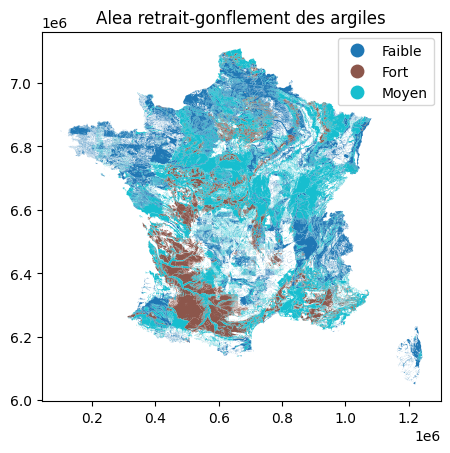

In [4]:
import matplotlib.pyplot as plt

ax = gdf.plot(column="ALEA", legend=True)
plt.title("Alea retrait-gonflement des argiles")
plt.show()


In [5]:
df = pd.read_excel("generales.xlsx") 
df.head()

,Hotel_ID,Hotel_name,region,type_loca,Latitude,Longitude
0,HOTEL_001,Cottage Fields,Auvergne-Rhône-Alpes,campagne,46.1333,5.5550
1,HOTEL_002,The Old Barn Inn,Hauts-de-France,campagne,49.5000,3.3333
2,HOTEL_003,Cottage Fields,Auvergne-Rhône-Alpes,campagne,46.3333,3.1667
3,HOTEL_004,Hillside Haven,Provence-Alpes-Côte d'Azur,montagne,44.1000,6.2333
4,HOTEL_005,Eagle's Nest Inn,Provence-Alpes-Côte d'Azur,montagne,44.6667,6.3333


In [6]:
df.columns

Index(['Hotel_ID', 'Hotel_name', 'region', 'type_loca', 'Latitude',
       'Longitude'],
      dtype='object')

In [7]:
gdf_alea_wgs84 = gdf.to_crs(epsg=4326)  # passage Lambert-93 -> WGS84 (lon/lat)


In [8]:
gdf_hotels = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
    crs="EPSG:4326"   # très important : même CRS que gdf_alea_wgs84
)

In [9]:
# On ne garde que ce qui est utile côté aléa
gdf_alea_sel = gdf_alea_wgs84[["ALEA", "NIVEAU", "geometry"]]

gdf_hotels_alea = gpd.sjoin(
    gdf_hotels,
    gdf_alea_sel,
    how="left",        # on garde tous les hôtels
    predicate="within" # hôtel à l'intérieur du polygone
)

gdf_hotels_alea.head()


,Hotel_ID,Hotel_name,region,type_loca,Latitude,Longitude,geometry,index_right,ALEA,NIVEAU
0,HOTEL_001,Cottage Fields,Auvergne-Rhône-Alpes,campagne,46.1333,5.5550,POINT (5.555 46.1333),117069.0,Faible,1.0
1,HOTEL_002,The Old Barn Inn,Hauts-de-France,campagne,49.5000,3.3333,POINT (3.3333 49.5),6528.0,Fort,3.0
2,HOTEL_003,Cottage Fields,Auvergne-Rhône-Alpes,campagne,46.3333,3.1667,POINT (3.1667 46.3333),36734.0,Moyen,2.0
3,HOTEL_004,Hillside Haven,Provence-Alpes-Côte d'Azur,montagne,44.1000,6.2333,POINT (6.2333 44.1),32811.0,Fort,3.0
4,HOTEL_005,Eagle's Nest Inn,Provence-Alpes-Côte d'Azur,montagne,44.6667,6.3333,POINT (6.3333 44.6667),36083.0,Faible,1.0


In [14]:
hotels_sans_alea = gdf_hotels_alea[gdf_hotels_alea["ALEA"].isna()]
print(len(hotels_sans_alea))
hotels_sans_alea.head()

56


,Hotel_ID,Hotel_name,region,type_loca,Latitude,Longitude,geometry,index_right,ALEA,NIVEAU
9,HOTEL_010,Hillside Homestead,Grand Est,campagne,48.3333,4.1667,POINT (4.1667 48.3333),NaN,NaN,NaN
11,HOTEL_012,Hillside Homestead,Occitanie,campagne,44.2833,2.5333,POINT (2.5333 44.2833),NaN,NaN,NaN
17,HOTEL_018,Central Station Hotel,Centre-Val de Loire,ville,47.0810,2.3988,POINT (2.3988 47.081),NaN,NaN,NaN
19,HOTEL_020,Downtown Stay,Corse,ville,41.9192,8.7386,POINT (8.7386 41.9192),NaN,NaN,NaN
21,HOTEL_022,Urban Retreat,Bourgogne-Franche-Comté,ville,47.3220,5.0415,POINT (5.0415 47.322),NaN,NaN,NaN


In [13]:
gdf_hotels_alea.drop(columns=["index_right"], errors="ignore").to_csv(
    "hotels_avec_alea.csv",
    index=False
)

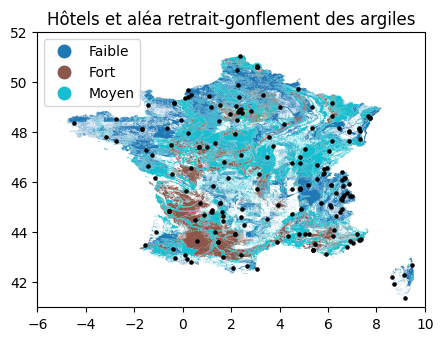

In [10]:
import matplotlib.pyplot as plt

ax = gdf_alea_wgs84.plot(column="ALEA", legend=True, figsize=(5,5))
gdf_hotels_alea.plot(ax=ax, color="black", markersize=5)

# Zoom sur la France métropolitaine
ax.set_xlim(-6, 10)   # longitudes
ax.set_ylim(41, 52)   # latitudes

plt.title("Hôtels et aléa retrait-gonflement des argiles")
plt.show()


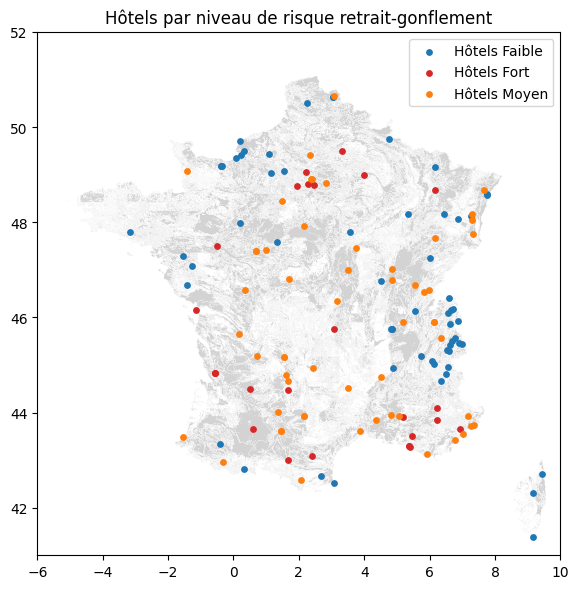

In [11]:
import matplotlib.pyplot as plt

# 1. Fond en gris clair, très discret
# 2. On s'assure que DPT est une string
gdf_alea_wgs84["DPT_str"] = gdf_alea_wgs84["DPT"].astype(str)
gdf_alea_metropole = gdf_alea_wgs84[
    ~gdf_alea_wgs84["DPT_str"].str.startswith(("97", "98"))
].drop(columns="DPT_str")
ax = gdf_alea_metropole.plot(
    figsize=(6, 6),
    color="lightgrey",
    edgecolor="white",
    linewidth=0.1
)

# 2. Hôtels colorés selon leur ALEA (récupéré après sjoin)
colors = {"Faible": "tab:blue", "Moyen": "tab:orange", "Fort": "tab:red"}

for alea, data in gdf_hotels_alea.dropna(subset=["ALEA"]).groupby("ALEA"):
    data.plot(
        ax=ax,
        markersize=15,
        marker="o",
        color=colors.get(alea, "black"),
        label=f"Hôtels {alea}"
    )

ax.set_xlim(-6, 10)
ax.set_ylim(41, 52)
ax.set_title("Hôtels par niveau de risque retrait-gonflement")
ax.legend()
plt.tight_layout()
plt.show()


In [12]:
gdf[["NIVEAU", "ALEA"]].drop_duplicates().sort_values(["NIVEAU", "ALEA"])


,NIVEAU,ALEA
2,1.0,Faible
0,2.0,Moyen
78,3.0,Fort
